#### Turnpike Property finite dimensional with uncertainty using Gekko library.

More information about Gekko : https://gekko.readthedocs.io/en/latest/CV_options.html 

Some examples of Gekko library: https://nbviewer.jupyter.org/url/apmonitor.com/wiki/uploads/Main/gekko.ipynb 

 #### Problem settings

Consider the probability space $(\Omega,\mathcal{F},\mathbb{P})$, and the following control systems

$$\begin{cases}x_{t}(t,\omega)+A(\omega)x(t,\omega)= B(\omega)u(t)\quad t\in (0,T),\omega\in\Omega,\\ x(0)=(1,1),\end{cases}$$

where $T=50$, $A(\omega)$ and  $B(\omega)$ denote two random matrix given by

$$ A(\omega) =\alpha \begin{pmatrix}0.2&0.5 \\-0.5&0.5\end{pmatrix},\quad B(\omega)=\beta\begin{pmatrix}0 \\1\end{pmatrix},$$

with $\alpha$ and $\beta$ random variables.
Let's consider the matrices

$$C=\begin{pmatrix}0&1 \\1&0\end{pmatrix},\quad z=\begin{pmatrix}2 \\3\end{pmatrix},$$ 

and the optimal control problem

$$\min_{u\in L^{2}(0,T;Y)}\lbrace J^{T}(u)=\frac{1}{2}\biggr(\int_{0}^{T}\Vert u\Vert^{2}_{Y}+\Vert Cx-z\Vert^{2}_{L^{2}(\Omega;X)}dt\biggr):\quad x \text{ solution of the above system}\rbrace. $$

where $X=\mathbb{R}^{n}$ and $Y=\mathbb{R}^{m}$. Finally, consider the stationary problem 

$$\min_{u\in Y}\lbrace J^{s}(u)=\frac{1}{2}\biggr(\Vert u\Vert^{2}_{Y}+\Vert Cx-z\Vert^{2}_{L^{2}(\Omega;X)}\biggr):\quad x \text{ solution of }Ax=Bu\rbrace. $$
In the following code, We are interested in solving these problems and show Turnpike property in an average sense. That is, show that the following inequality is satisfying

$$\Vert\,\mathbb{E}(x^{T})-\mathbb{E}(\overline{x})\,\Vert_{X}+\Vert u^{T}-\overline{u} \Vert_{Y}\leq K(e^{-\delta t}+e^{\delta(T-t)}),$$

where the pair $(x^{T},u^{T})$ is the optimal solution of the evolutive sistem, and the pair $(\overline{x},\overline{u})$ is the optimal solution of the stacionary problem. Here the constant $\delta$, $K$ are independent of $T$.

#### Code

We import the necessary libraries to solve the optimal control problems (GEKKO), the vectorial manipulation (Numpy), and the plotting

In [94]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.special


The following function **settings(examp, n_var)** has as outputs are the random variables and the weights associated with the probability measure. The parameters of this function are described below. 

1. examp: Choose the distribution of the random variables

    $\bullet$ examp == 'expo': Exponential distribution. <br>
    $\bullet$ examp == 'poiss': Poisson Distribution. <br>
    $\bullet$ examp == 'unif': Uniform Distribution.
  
2. n_var: Turn on or off the random variables 

    $\bullet$ n_var == [ 'alpha' ]: The variable  $\alpha$ is on and the variable $\beta$ is off ($\beta=1$).<br>
    $\bullet$ n_var == [ 'beta' ]: The variable $\alpha$ is off and the variable $\beta$ is on ($\alpha=1$).<br>
    $\bullet$ n_var == [ 'alpha' , 'beta' ]: Both $\alpha$ and $\beta$ are on.

In [68]:
def settings(examp, n_var):
    obs=7
    pesos = pesos_var(examp,obs)

    if len(n_var) == 1:
        if n_var[0]=='alpha':
            alpha = variable(examp,len(n_var),obs)
            beta = np.linspace(1,1,obs)
        elif n_var[0]=='beta':
            alpha = np.linspace(1,1,obs)
            beta = variable(examp,len(n_var),obs)
        else:
            print('Error: Wrong variable name.')
            return None
    elif len(n_var) == 2:
        alpha = variable(examp,len(n_var)-1,obs)
        beta = variable(examp,len(n_var),obs)
    else:
        print(n_var)
        print('Error: Wrong variable name.')
    return alpha, beta, pesos   

The next function allow us to obtain the random values to each random variable. It function depends of the parameters *examp* to choose the distribution of the random variables, *n_var* to generate a diferent seed (and different random values for each random variable), and *obs*  the number of realizations observed (in our code always is seven). 

In [150]:
def variable(examp,n_var_len,obs):
    np.random.seed(n_var_len+11)
    if examp=='expo':
        lamb= 7
        return np.random.exponential(scale= lamb,size= obs)
    if examp=='poiss':
        lamb=5
        return np.random.poisson(lamb, obs)
    if examp=='unif':
        lim_inf=1/2
        lim_sup=2
        return np.random.uniform(lim_inf,lim_sup,obs)
    else:
        print('Error: Wrong example name.')
    return

The function below gives us the weights associate with each probability distribution. To do this is necessary the parameters *examp* and *obs*

In [151]:
def pesos_var(examp,obs):
    if examp=='expo':
        lamb= 5
        vector = np.linspace(0,2/lamb,obs)
        return np.exp(-lamb*vector)*lamb
    if examp=='poiss':        
        lamb=5
        lambsqrt=lamb**(1/2)
        vector = np.linspace(lamb-2*lambsqrt,lamb+2*lambsqrt,obs)
        poisson=np.exp(-lamb)*np.power(lamb, vector)/(scipy.special.factorial(vector) )
        return np.exp(-lamb)*np.power(lamb, vector)/( vector )
    if examp=='unif':
        lim_inf=1/2
        lim_sup=2
        return np.linspace(lim_inf,lim_sup,obs)
    else:
        print('Error: Wrong example name.')
    return
    
    

Finally, the next code is the main module. This module solves the optimal control problem. It has as input the matrix of the problem, the random variables, the weights, and the initial and final times.

In [36]:
def main_code_turnpike_7_realiz(A,B,C,Z,alpha,beta,pesos,ti,tf):
    
    ################################ settings #####################################
    # In this module, we consider the problem announced above, with seven realizations of the random variables.
    # In the case of a continuous distribution, we take a discretization around the mean of the random variable.
    ###############################################################################
    
    nu1 = alpha[0]
    nu2 = alpha[1]
    nu3 = alpha[2]
    nu4 = alpha[3]
    nu5 = alpha[4]
    nu6 = alpha[5]
    nu7 = alpha[6]

    beta1 = beta[0]
    beta2 = beta[1]
    beta3 = beta[2]
    beta4 = beta[3]
    beta5 = beta[4]
    beta6 = beta[5]
    beta7 = beta[6]

    p1 = pesos[0]
    p2 = pesos[1]
    p3 = pesos[2]
    p4 = pesos[3]
    p5 = pesos[4]
    p6 = pesos[5]
    p7 = pesos[6]    


    a11=A[0,0]  ; a12=A[0,1]
    a21=A[1,0]  ; a22=A[1,1]



    b1=B[0,0]
    b2=B[1,0]

    z1=Z[0,0]
    z2=Z[1,0]

    c11=C[0,0]  ; c12=C[0,1]
    c21=C[1,0]  ; c22=C[1,1]  

    
    ################################ Evolutive Problem #####################################

    m = GEKKO() # initialize gekko
    nt = 101
    m.time = np.linspace(ti,tf,nt)

    # Initialize variables with his respectively initial condition (1,1)    
    x1 = m.Var(value=1) #to omega=1
    x2 = m.Var(value=1)

    x3 = m.Var(value=1) #to omega=2
    x4 = m.Var(value=1)

    x5 = m.Var(value=1) #to omega=3
    x6 = m.Var(value=1)

    x7 = m.Var(value=1) #to omega=4
    x8 = m.Var(value=1)


    x9 = m.Var(value=1) #to omega=5
    x10 = m.Var(value=1)

    x11 = m.Var(value=1) #to omega=6
    x12 = m.Var(value=1)

    x13 = m.Var(value=1) #to omega=7
    x14 = m.Var(value=1)



    x21 = m.Var(value=0) #objetive variable


    u = m.Var(value=0) #Control

    p = np.zeros(nt) # mark final time point
    p[-1] = 1.0
    final = m.Param(value=p)


    # Equations for each realization
    
    m.Equation(x1.dt()==-a11*x1*nu1  -  a12*x2*nu1  +  b1*u*beta1)   #to omega=1
    m.Equation(x2.dt()==-a21*x1*nu1  -  a22*x2*nu1  +  b2*u*beta1)

    m.Equation(x3.dt()==-a11*x3*nu2  -  a12*x4*nu2  +  b1*u*beta2)   #to omega=2
    m.Equation(x4.dt()==-a21*x3*nu2  -  a22*x4*nu2  +  b2*u*beta2)

    m.Equation(x5.dt()==-a11*x5*nu3  -  a12*x6*nu3  +  b1*u*beta3)   #to omega=3
    m.Equation(x6.dt()==-a21*x5*nu3  -  a22*x6*nu3  +  b2*u*beta3)

    m.Equation(x7.dt()==-a11*x7*nu4  -  a12*x8*nu4  +  b1*u*beta4)   #to omega=4
    m.Equation(x8.dt()==-a21*x7*nu4  -  a22*x8*nu4  +  b2*u*beta4)

    m.Equation(x9.dt()==-a11*x9*nu5  -  a12*x10*nu5  +  b1*u*beta5)   #to omega=5
    m.Equation(x10.dt()==-a21*x9*nu5  -  a22*x10*nu5  +  b2*u*beta5)

    m.Equation(x11.dt()==-a11*x11*nu6  -  a12*x12*nu6  +  b1*u*beta6)   #to omega=6
    m.Equation(x12.dt()==-a21*x11*nu6  -  a22*x12*nu6  +  b2*u*beta6)

    m.Equation(x13.dt()==-a11*x13*nu7  -  a12*x14*nu7  +  b1*u*beta7)   #to omega=7
    m.Equation(x14.dt()==-a21*x13*nu7  -  a22*x14*nu7  +  b2*u*beta7)



    #Objetive function argument
    m.Equation(x21.dt()==0.5*u**2+(0.5)*((( p1*(x1*c11+x2*c12)-z1)**2    + p1*((c21*x1+x2*c22)-z2)**2
                                         +  p2*((x3*c11+x4*c12)-z1)**2   + p2*((c21*x3+x4*c22)-z2)**2
                                         +  p3*((x5*c11+x6*c12)-z1)**2   + p3*((c21*x5+x6*c22)-z2)**2
                                         +  p4*((x7*c11+x8*c12)-z1)**2   + p4*((c21*x7+x8*c22)-z2)**2
                                         +  p5*((x9*c11+x10*c12)-z1)**2  + p5*((c21*x9+x10*c22)-z2)**2
                                         +  p6*((x11*c11+x12*c12)-z1)**2 + p6*((c21*x11+x12*c22)-z2)**2
                                         +  p7*((x13*c11+x14*c12)-z1)**2 + p7*((c21*x13+x14*c22)-z2)**2)))


    m.Obj(x21*final) # Objective function
    m.options.IMODE = 6 # optimal control mode
    m.solve(disp=False) # solve

    # Save the results

    vector_x1=x1.value
    vector_x2=x2.value
    vector_x3=x3.value
    vector_x4=x4.value
    vector_x5=x5.value
    vector_x6=x6.value
    vector_x7=x7.value
    vector_x8=x8.value
    vector_x9=x9.value
    vector_x10=x10.value
    vector_x11=x11.value
    vector_x12=x12.value
    vector_x13=x13.value
    vector_x14=x14.value



    vector_u=u.value
    tiempo=m.time



    ################################### Stationary Problem #####################################

    m = GEKKO() # Initialize gekko
    # Use IPOPT solver (default)
    m.options.SOLVER = 3
    # Change to parallel linear solver
    m.solver_options = ['linear_solver ma97']
   
    # Initialize variables
    xl1 = m.Var()
    xl2 = m.Var()
    xl3 = m.Var()
    xl4 = m.Var()
    xl5 = m.Var()
    xl6 = m.Var()
    xl7 = m.Var()
    xl8 = m.Var()
    xl9 = m.Var()
    xl10 = m.Var()
    xl11 = m.Var()
    xl12 = m.Var()
    xl13 = m.Var()
    xl14 = m.Var()

    ul = m.Var()
    # Equations
    m.Equation(a11*xl1*nu1  +  a12*xl2*nu1  ==  b1*ul*beta1) #nu 1
    m.Equation(a21*xl1*nu1  +  a22*xl2*nu1  ==  b2*ul*beta1)

    m.Equation(a11*xl3*nu2  +  a12*xl4*nu2  ==  b1*ul*beta2) #nu 2
    m.Equation(a21*xl3*nu2  +  a22*xl4*nu2  ==  b2*ul*beta2)

    m.Equation(a11*xl5*nu3  +  a12*xl6*nu3  ==  b1*ul*beta3) #nu 3
    m.Equation(a21*xl5*nu3  +  a22*xl6*nu3  ==  b2*ul*beta3)

    m.Equation(a11*xl7*nu4  +  a12*xl8*nu4  ==  b1*ul*beta4) #nu 4
    m.Equation(a21*xl7*nu4  +  a22*xl8*nu4  ==  b2*ul*beta4)

    m.Equation(a11*xl9*nu5  +  a12*xl10*nu5  ==  b1*ul*beta5) #nu 5
    m.Equation(a21*xl9*nu5  +  a22*xl10*nu5  ==  b2*ul*beta5)

    m.Equation(a11*xl11*nu6  +  a12*xl12*nu6  ==  b1*ul*beta6) #nu 6
    m.Equation(a21*xl11*nu6  +  a22*xl12*nu6  ==  b2*ul*beta6)

    m.Equation(a11*xl13*nu7  +  a12*xl14*nu7  ==  b1*ul*beta7) #nu 7
    m.Equation(a21*xl13*nu7  +  a22*xl14*nu7  ==  b2*ul*beta7)



    m.Obj(0.5*ul**2+(0.5)*( p1*((xl1*c11+xl2*c12)-z1)**2   + p1*((c21*xl1+xl2*c22)-z2)**2
                          + p2*((xl3*c11+xl4*c12)-z1)**2   + p2*((c21*xl3+xl4*c22)-z2)**2
                          + p3*((xl5*c11+xl6*c12)-z1)**2   + p3*((c21*xl5+xl6*c22)-z2)**2
                          + p4*((xl7*c11+xl8*c12)-z1)**2   + p4*((c21*xl7+xl8*c22)-z2)**2
                          + p5*((xl9*c11+xl10*c12)-z1)**2  + p5*((c21*xl9+xl10*c22)-z2)**2
                          + p6*((xl11*c11+xl12*c12)-z1)**2 + p6*((c21*xl11+xl12*c22)-z2)**2
                          + p7*((xl13*c11+xl14*c12)-z1)**2 + p7*((c21*xl13+xl14*c22)-z2)**2)) # Objective


    m.options.IMODE = 3 # Steady state optimization
    m.solve(disp=False) # Solve

    #Create constant vectors, with the outputs values

    vector_xl1= (np.linspace(0.1,2,nt)/np.linspace(0.1,2,nt))*xl1.value
    vector_xl2= (np.linspace(0.1,2,nt)/np.linspace(0.1,2,nt))*xl2.value
    vector_xl3= (np.linspace(0.1,2,nt)/np.linspace(0.1,2,nt))*xl3.value
    vector_xl4= (np.linspace(0.1,2,nt)/np.linspace(0.1,2,nt))*xl4.value
    vector_xl5= (np.linspace(0.1,2,nt)/np.linspace(0.1,2,nt))*xl5.value
    vector_xl6= (np.linspace(0.1,2,nt)/np.linspace(0.1,2,nt))*xl6.value
    vector_xl7= (np.linspace(0.1,2,nt)/np.linspace(0.1,2,nt))*xl7.value
    vector_xl8= (np.linspace(0.1,2,nt)/np.linspace(0.1,2,nt))*xl8.value
    vector_xl9= (np.linspace(0.1,2,nt)/np.linspace(0.1,2,nt))*xl9.value
    vector_xl10= (np.linspace(0.1,2,nt)/np.linspace(0.1,2,nt))*xl10.value
    vector_xl11= (np.linspace(0.1,2,nt)/np.linspace(0.1,2,nt))*xl11.value
    vector_xl12= (np.linspace(0.1,2,nt)/np.linspace(0.1,2,nt))*xl12.value
    vector_xl13= (np.linspace(0.1,2,nt)/np.linspace(0.1,2,nt))*xl13.value
    vector_xl14= (np.linspace(0.1,2,nt)/np.linspace(0.1,2,nt))*xl14.value

    vector_ul= (np.linspace(0.1,2,nt)/np.linspace(0.1,2,nt))*ul.value

    
    vl=[vector_xl1,vector_xl2,vector_xl3,vector_xl4,vector_xl5,vector_xl6,vector_xl7,vector_xl8,vector_xl9,vector_xl10,vector_xl11,vector_xl12,vector_xl13,vector_xl14]
    
    vx=[vector_x1,vector_x2,vector_x3,vector_x4,vector_x5,vector_x6,vector_x7,vector_x8,vector_x9,vector_x10,vector_x11,vector_x12,vector_x13,vector_x14]
    
        
    #We calculate the norm of the differences between the states and controls, evolutionary and stationary

    dif_x=(( p1*(vector_xl1-vector_x1)**2   + p1*(vector_xl2-vector_x2)**2
           + p2*(vector_xl3-vector_x3)**2   + p2*(vector_xl4-vector_x4)**2
           + p3*(vector_xl5-vector_x5)**2   + p3*(vector_xl6-vector_x6)**2
           + p4*(vector_xl7-vector_x7)**2   + p4*(vector_xl8-vector_x8)**2
           + p5*(vector_xl9-vector_x9)**2   + p5*(vector_xl10-vector_x10)**2
           + p6*(vector_xl11-vector_x11)**2 + p6*(vector_xl12-vector_x12)**2
           + p7*(vector_xl13-vector_x13)**2 + p7*(vector_xl14-vector_x14)**2))**(1/2)


    dif_u=((vector_ul-vector_u)**2)**(1/2)
    
    print('End')
    return(dif_x,dif_u,vl,vx,vector_ul,vector_u,tiempo)

In the next module we plot the figures.

In [239]:
def plot_figures(dif_x,dif_u,vl,vx,vector_ul,vector_u,tiempo,sett_plot=None, save=False , number=0):
    
    ################################ settings #####################################
     
    
    vector_x1 = vx[0]
    vector_x2 = vx[1]
    vector_x3 = vx[2]
    vector_x4 = vx[3]
    vector_x5 = vx[4]
    vector_x6 = vx[5]
    vector_x7 = vx[6]
    vector_x8 = vx[7]
    vector_x9 = vx[8]
    vector_x10 = vx[9]
    vector_x11 = vx[10]
    vector_x12 = vx[11]
    vector_x13 = vx[12]
    vector_x14 = vx[13]
    
    vector_xl1 = vl[0]
    vector_xl2 = vl[1]
    vector_xl3 = vl[2]
    vector_xl4 = vl[3]
    vector_xl5 = vl[4]
    vector_xl6 = vl[5]
    vector_xl7 = vl[6]
    vector_xl8 = vl[7]
    vector_xl9 = vl[8]
    vector_xl10 = vl[9]
    vector_xl11 = vl[10]
    vector_xl12 = vl[11]
    vector_xl13 = vl[12]
    vector_xl14 = vl[13]
    
    dato_xT1=(vector_x1,vector_x3,vector_x5,vector_x7,vector_x9,vector_x11,vector_x13)
    dato_xT2=(vector_x2,vector_x4,vector_x6,vector_x8,vector_x10,vector_x12,vector_x14)

    dato_xL1=(vector_xl1,vector_xl3,vector_xl5,vector_xl7,vector_xl9,vector_xl11,vector_xl13)
    dato_xL2=(vector_xl2,vector_xl4,vector_xl6,vector_xl8,vector_xl10,vector_xl12,vector_xl14)

    if sett_plot==None:
        sett_plot=['best','best','best','best','best','best','best','upper center']
    
    ######## Estimate the average trayectories

    trayectoria_prom_T1=np.mean(dato_xT1,axis=0)
    trayectoria_prom_T2=np.mean(dato_xT2,axis=0)

    trayectoria_prom_L1=np.mean(dato_xL1,axis=0)
    trayectoria_prom_L2=np.mean(dato_xL2,axis=0)

    des_xt1=np.std(dato_xT1)
    des_xt2=np.std(dato_xT2)

    des_xl1=np.std(dato_xL1)
    des_xl2=np.std(dato_xL2)

    prom_t1=np.mean(dato_xT1)
    prom_t2=np.mean(dato_xT2)

    prom_l1=np.mean(dato_xL1)
    prom_l2=np.mean(dato_xL2)

    ######## Plot the evolutives trayectories (realization) and the average

    
    plt.figure(1)    

    plt.subplot(2,1,1)
    plt.title("Evolutive")
    plt.plot(tiempo,vector_x1,'g-', color='#8e94fa')
    plt.plot(tiempo,vector_x3,'b-', color='#abd6bc')
    plt.plot(tiempo,vector_x5,'m-', color='#d1d490')
    plt.plot(tiempo,vector_x7,'g-', color='#89d6ce')
    plt.plot(tiempo,vector_x9,'m-', color='#d5abd6')
    plt.plot(tiempo,vector_x11,'r-', color='#d6abab')
    plt.plot(tiempo,vector_x13,'r-', color='#fee0ff')
    plt.plot(tiempo,trayectoria_prom_T1,'k--', color='#000000',label=r'$Average\; Trajectory\; of\; x^{T}_1(t)$')
    plt.legend(loc=sett_plot[0])
    plt.ylabel('Values')

    plt.subplot(2,1,2)
    plt.plot(tiempo,vector_x2,'g-', color='#89d6ce')
    plt.plot(tiempo,vector_x4,'m-', color='#d5abd6')
    plt.plot(tiempo,vector_x6,'r-', color='#d6abab')
    plt.plot(tiempo,vector_x8,'g-', color='#89d6ce')
    plt.plot(tiempo,vector_x10,'m-', color='#d5abd6')
    plt.plot(tiempo,vector_x12,'r-', color='#d6abab')
    plt.plot(tiempo,vector_x14,'r-', color='#fee0ff')
    plt.plot(tiempo,trayectoria_prom_T2,'k--', color='#000000',label=r'$Average\; Trajectory\; of\; x^{T}_2(t)$')
    plt.legend(loc=sett_plot[1])
    plt.ylabel('Values')
    plt.xlabel('Time')
    
    if save:
        plt.savefig('plot_'+str(1+4*number)+'.png')

    
    ######## Plot the stationary trayectories (realization) and the average
    
    plt.figure(2)    
    plt.subplot(2,1,1)
    plt.title("Stationary")
    plt.plot(tiempo,vector_xl1,'g-', color='#8e94fa')
    plt.plot(tiempo,vector_xl3,'b-', color='#abd6bc')
    plt.plot(tiempo,vector_xl5,'m-', color='#d1d490')
    plt.plot(tiempo,vector_xl7,'g-', color='#89d6ce')
    plt.plot(tiempo,vector_xl9,'m-', color='#d5abd6')
    plt.plot(tiempo,vector_xl11,'r-', color='#d6abab')
    plt.plot(tiempo,vector_xl13,'r-', color='#fee0ff')
    plt.plot(tiempo,trayectoria_prom_L1,'k--', color='#000000',label=r'$Average\; Trajectory\; of\; \overline{x}_1$')
    #plt.axhline(y=2*des_xl1+prom_l1,color='#c9c9c7', linestyle ="--")
    #plt.axhline(y=-2*des_xl1+prom_l1,color='#c9c9c7', linestyle ="--")
    plt.legend(loc=sett_plot[2])
    plt.ylabel('Values')

    plt.subplot(2,1,2)
    plt.plot(tiempo,vector_xl2,'g-', color='#89d6ce')
    plt.plot(tiempo,vector_xl4,'m-', color='#d5abd6')
    plt.plot(tiempo,vector_xl6,'r-', color='#d6abab')
    plt.plot(tiempo,vector_xl8,'g-', color='#89d6ce')
    plt.plot(tiempo,vector_xl10,'m-', color='#d5abd6')
    plt.plot(tiempo,vector_xl12,'r-', color='#d6abab')
    plt.plot(tiempo,vector_xl14,'r-', color='#fee0ff')
    plt.plot(tiempo,trayectoria_prom_L2,'k--', color='#000000',label=r'$Average\; Trajectory\; of\; \overline{x}_2$')
    plt.legend(loc=sett_plot[3])
    plt.xlabel('Time')
    plt.ylabel('Values')
    if save:
        plt.savefig('plot_'+str(2+4*number)+'.png')


    
    ####### Plot the supersosition of the average trayectories
    
    plt.figure(3)
    plt.subplot(2,1,1)
    plt.plot(tiempo,trayectoria_prom_T1,'k--', color='#0e00d1',label=r'$Average\; Trajectory\; of\; x^{T}_1(t)$')
    plt.plot(tiempo,trayectoria_prom_L1,'k--', color='#0fb004',label=r'$Average\; Trajectory\; of\; \overline{x}_1$')
    plt.legend(loc=sett_plot[4])
    plt.xlabel('Time')
    plt.ylabel('Values')
    
    plt.subplot(2,1,2)
    plt.plot(tiempo,trayectoria_prom_T2,'k--', color='#0e00d1',label=r'$Average\; Trajectory\; of\; x^{T}_2(t)$')
    plt.plot(tiempo,trayectoria_prom_L2,'k--', color='#0fb004',label=r'$Average\; Trajectory\; of\; \overline{x}_2$')
    plt.legend(loc=sett_plot[5])
    plt.xlabel('Time')
    plt.ylabel('Values')
    if save:
        plt.savefig('plot_'+str(3+4*number)+'.png')


    
    ####### Plot the control an state norms

    plt.figure(4)
    plt.subplot(2,1,1)
    plt.plot(tiempo,vector_u,'k--', color='#0e00d1',label=r'$Evolutive \;Control\; u^{T}(t)$')
    plt.plot(tiempo,vector_ul,'k--', color='#0fb004',label=r'$Stationary\;Control\;\overline{u}$')
    plt.legend(loc=sett_plot[6])
    plt.xlabel('Time')
    plt.ylabel('Values')
    
    plt.subplot(2,1,2)
    plt.plot(tiempo,dif_x,'r-',label=r'$||\mathbb{E}(x^{T}(t))-\mathbb{E}(\overline{x})||$')
    plt.plot(tiempo,dif_u,'k-',label=r'$||u^{T}(t)-\overline{u}||$')
    plt.legend(loc=sett_plot[7])
    plt.xlabel('Time')
    plt.ylabel('Values')

    if save:
        plt.savefig('plot_'+str(4+4*number)+'.png')

    return

Now we illustrate how can we use the above codes to solve the optimal control problems, and show the Turnpike Property.

In [252]:
################# PARAMETERS #########################

# We consider a inicial time t=0 an final time T=50.
ti=0
tf=10   # If the turnpike property cannot be seen clearly, the time horizon (tf) should be longer, for example tf=500.

# Estimate the random variables
#settings(examp, n_var) you can choose one of the following options (opx)

op1=['alpha']
op2=['beta']
op3=['alpha','beta']

alpha, beta, pesos = settings('poiss',op3)

# The structure of the matrices
A=np.matrix(' 0.2 0.5  ;  -0.5 0.5 ')
B=np.matrix('0  ;  1')
Z= np.matrix('2  ; 3')
C=np.matrix(' 0 1  ;  1  0 ')

# Solve the problem
dif_x,dif_u,vl,vx,vector_ul,vector_u,tiempo = main_code_turnpike_7_realiz(A,B,C,Z,alpha,beta,pesos,ti,tf)
# The function returns an 'End' message when it finishes.

End


Finally, we plot the trayectories.

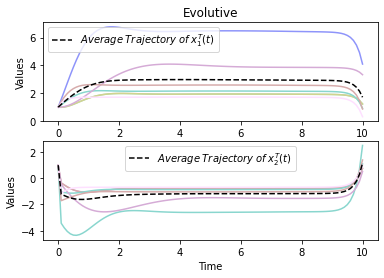

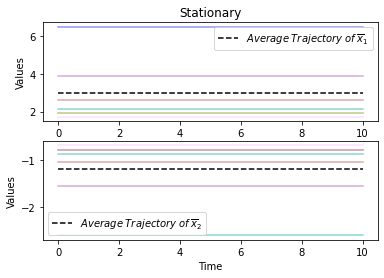

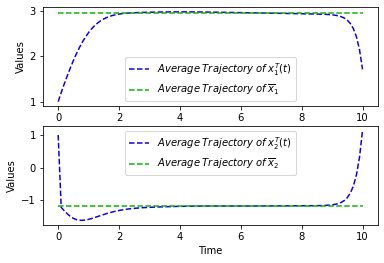

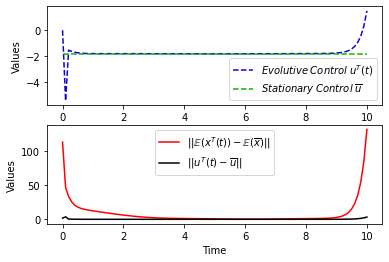

In [253]:
# Optional variables, for the legend positions
#sett_plot=['lower center','upper center','upper right','lower right','lower center','best','lower center','upper center']

plot_figures(dif_x,dif_u,vl,vx,vector_ul,vector_u,tiempo,sett_plot=None)

In this final plot, we can evidence the Turnpike Property in the average of the optimal trajectories.

**Remark:** If the turnpike property cannot be seen clearly, the time horizon (tf) should be longer, for example tf=500.